In [32]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim



from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from datetime import datetime

from sklearn.model_selection import train_test_split


In [17]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [18]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]

img_noisyDataSet1 = np.expand_dims(img_noisyDataSet1, axis=-3)
img_noisyDataSet2 = np.expand_dims(img_noisyDataSet2, axis=-3)
img_groundTruth = np.expand_dims(img_groundTruth, axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [19]:
# Acoto conjuntos (OPCIONAL)

img_noisyDataSet1 =img_noisyDataSet1[30:50,:,:,:]
img_noisyDataSet2 =img_noisyDataSet2[30:50,:,:,:]
img_groundTruth =img_groundTruth[30:50,:,:,:]

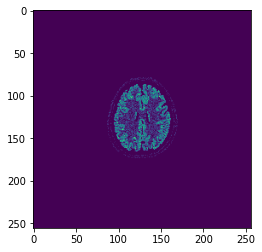

In [5]:
plt.imshow(img_noisyDataSet1[19,0,:,:])

In [6]:
# Error cuadratico medio entre dos imagenes

def MSE(img1, img2):
        cuadradoDeDif = ((img1 -img2) ** 2)
        suma = np.sum(cuadradoDeDif)
        cantPix = img1.shape[0] * img1.shape[1] 
        error = suma / cantPix
        return error

In [7]:
MSE_dataSet1_slice = MSE(img_noisyDataSet1[5,0,:,:],img_groundTruth[5,0,:,:])
print(MSE_dataSet1_slice)

0.35028509543889563


In [8]:
#Unet CLASICA (generando un nuevo formato)

class DownConv(nn.Module):
    
    def __init__(self, in_channels , out_channels, kernel_size = 3 , stride = 1 , padding = 1):
        super(DownConv, self).__init__()
        self.DownLayer = nn.Sequential(

            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(out_channels2),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        
        def forward(self, x ):
            x = self.DownLayer(x)
            return x
        
class MaxPool(nn.Module):
    def __init__(self, kernel_size = 2, stride = 2):
        super(MaxPool, self).__init__()
        self.Pool = torch.nn.MaxPool2d()
        
    def forward (self,x):
        x = self.Pool(x)
        return x
    
class Middle(nn.Module): 
    def __init__(self, kernel_size = 2, stride = 2):
        super(Middle, self).__init__()
        self.Pool = torch.nn.MaxPool2d()
        
class UpConv(nn.Module):
    
    def __init__(self, in_channels , out_channels, kernel_size = 3 , stride = 1 , padding = 1):
        super(UpConv, self).__init__()
        
        self.ConvTransp = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.UpConv = self.DownLayer(in_channels, out_channels)
        
    def forward(self, xAnt , xDown):
            
        layerConvTransposed = self.ConvTransposed(xAnt)
        concat = torch.cat((layerConvTransposed,xDown), dim=1)
        x = self.UpConv(concat)
            
        return x
    

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self,x).__init__()
        
        # Contract
        
        self.Layer1Down = self.DownConv(1,32)
        self.Layer2Down = self.DownConv(32,64)
        self.Layer3Down = self.DownConv(64,128)
        self.Layer4Down = self.DownConv(128,256)
        self.Layer5Down = self.DownConv(256,512)
        self.Layer6Down = self.DownConv(512,1024)
        
        self.Layer1Up = self.UpConv(1024,512)
        self.Layer2Up = self.UpConv(512,256)
        self.Layer3Up = self.UpConv(256,128)
        self.Layer4Up = self.UpConv(128,64)
        self.Layer5Up = self.UpConv(64,32)
        
        
    
    def forward(self, x):

        # Down
        conv1 = self.layer1Down(x)
        maxPool1 = self.MaxPool(conv1)
        
        conv2 = self.layer2Down(maxPool1)
        maxPool2 = self.Pooling(conv2)
        
        conv3 = self.layer3Down(maxPool2)
        maxPool3 = self.Pooling(conv3)
        
        conv4 = self.layer4Down(maxPool3)
        maxPool4 = self.Pooling(conv4)
        
        conv5 = self.layer5Down(maxPool4)
        maxPool5 = self.Pooling(conv5)
        
        conv6 = self.layer6Down(maxPool5)
        

        # Up
        
        layerConvTransposed = self.layer7ConvTransposed(conv7)
        layer6UpData = torch.cat((layerConvTransposed,conv6), dim=1)
        convTrans6 = self.layer6Up(layer6UpData)
        
        layerConvTransposed = self.layer6ConvTransposed(convTrans6)
        layer5UpData = torch.cat((layerConvTransposed,conv5), dim=1)
        convTrans5 = self.layer5Up(layer5UpData)
        
        layerConvTransposed = self.layer5ConvTransposed(convTrans5)
        layer4UpData = torch.cat((layerConvTransposed,conv4), dim=1)
        convTrans4 = self.layer4Up(layer4UpData)        
 
        layerConvTransposed = self.layer4ConvTransposed(convTrans4)
        layer3UpData = torch.cat((layerConvTransposed,conv3), dim = 1)
        convTrans3 = self.layer3Up(layer3UpData)
        
        layerConvTransposed = self.layer3ConvTransposed(convTrans3)
        layer2UpData = torch.cat((layerConvTransposed,conv2), dim = 1)
        convTrans2 = self.layer2Up(layer2UpData)
        
        layerConvTransposed = self.layer2ConvTransposed(convTrans2)
        layer1UpData = torch.cat((layerConvTransposed,conv1), dim = 1)
        convTrans1 = self.layer1Up(layer1UpData)
        
        outNet = torch.nn.Conv2d(32,1, kernel_size = 1)(convTrans1)
        return outNet

unet = Unet()

In [20]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]
    

In [25]:
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.expand_dims(inputs, axis=-3)
    inputs = torch.Tensor(inputs)
    print(inputs.shape)
    out = unet(inputs)


summary(unet,inputs )

torch.Size([1, 1, 256, 256])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        320
|    └─BatchNorm2d: 2-2                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,248
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 32, 128, 128]        --
├─Sequential: 1-3                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─BatchNorm2d: 2-8                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-9                         [-1, 64, 128, 128]        --
|    └─Conv2d: 2-10                      [-1, 6

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        320
|    └─BatchNorm2d: 2-2                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,248
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 32, 128, 128]        --
├─Sequential: 1-3                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─BatchNorm2d: 2-8                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-9                         [-1, 64, 128, 128]        --
|    └─Conv2d: 2-10                      [-1, 64, 128, 128]        36,928
| 

In [27]:
# Prueba con un slice 
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.expand_dims(inputs, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)
    
gT = train_groundTruth[5]
gT = np.expand_dims(gT, axis=-3)
gT = torch.Tensor(gT)

inputs_np = inputs.detach().numpy()
out_np = out.detach().numpy()
gT_np = gT.detach().numpy()

MSE_orig = MSE(inputs_np[0,0,:,:],gT_np[0,0,:,:])
MSE_test = MSE(out_np[0,0,:,:],gT_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputs_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsNoTrain.nii')

img_out = sitk.GetImageFromArray(out_np[0,0,:,:])
sitk.WriteImage(img_out,'outNoTrain.nii')


img_gT = sitk.GetImageFromArray(gT_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthNoTrain.nii')

MSE orig 0.361245721578598
MSE test 3.4664862155914307


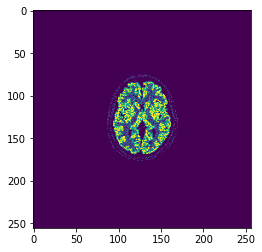

In [28]:
scaleForVisualization = 1.2*gT_np.max()

plt.imshow(inputs_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

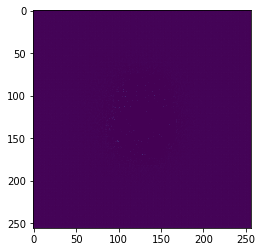

In [29]:
plt.imshow(out_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [30]:
# Codigo de pag Pythorch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.expand_dims(inputs, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.expand_dims(trainGroundTruth, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss en las ultimas 10 imagenes
            print('  image {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * ((train_noisyImage.shape[0])/10) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [33]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    unet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    unet.train(False)

    running_vloss = 0.0
    for i in range(0, valid_noisyImage.shape[0]):
        
        vinputs = valid_noisyImage[i]
        vinputs = np.expand_dims(vinputs, axis=-3)
        vinputs = torch.Tensor(vinputs)
        
        validGroundTruth = valid_groundTruth[i]
        validGroundTruth = np.expand_dims(validGroundTruth, axis=-3)
        validGroundTruth = torch.Tensor(validGroundTruth)
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, validGroundTruth)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        unet_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(unet.state_dict(), unet_path)

    epoch_number += 1

EPOCH 1:
  image 10 loss: 2.6650085926055906
LOSS train 2.6650085926055906 valid 2.2044968605041504


c:\users\ecyt\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\module.py:1384: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  " and ".join(warn_msg) + " are deprecated. nn.Module.state_dict will not accept them in the future. "


EPOCH 2:
  image 10 loss: 2.218086802959442
LOSS train 2.218086802959442 valid 2.137843608856201
EPOCH 3:
  image 10 loss: 2.371558690071106
LOSS train 2.371558690071106 valid 2.2909998893737793
EPOCH 4:


KeyboardInterrupt: 

In [ ]:
plt.imshow(inputsTrain_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [ ]:
plt.imshow(outTrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [ ]:
plt.imshow(gTtrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [ ]:
# CONJUNTO DE TESTEO

if __name__ == '__main__':
    inputsTest = test_noisyImage[1]
    inputsTest = np.expand_dims(inputsTest, axis=-3)
    inputsTest = torch.Tensor(inputsTest)
    model = Unet()
    outTest = unet(inputsTest)
    
gTtest = test_groundTruth[1]
gTtest = np.expand_dims(gTtest, axis=-3)
gTtest = torch.Tensor(gTtest)

inputsTest_np = inputsTest.detach().numpy()
outTest_np = outTest.detach().numpy()
gTtest_np = gTtest.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTest_np[0,0,:,:],gTtest_np[0,0,:,:])
MSE_test = MSE(outTest_np[0,0,:,:],gTtest_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputsTest_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTest.nii')

img_out = sitk.GetImageFromArray(outTest_np[0,0,:,:])
sitk.WriteImage(img_out,'outTest.nii')

img_gTtest = sitk.GetImageFromArray(gTtest_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthtest.nii')

In [ ]:
plt.imshow(inputsTest_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [ ]:
plt.imshow(outTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )